In [282]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_lightning import seed_everything
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import os
from pathlib import Path
import shutil
import gzip
import requests
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
%matplotlib inline

# set seed 
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
seed_number = 42
seed = set_seed(seed_number)

Global seed set to 42


# load data

In [283]:
X_train = pd.read_feather('../data/X_train.feather')
y_train = pd.read_feather('../data/y_train.feather')
X_test = pd.read_feather('../data/X_test.feather')
y_test = pd.read_feather('../data/y_test.feather')
display(X_test.head())
display(y_test.head())

,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.0,4.0,8.0,1.0,1.0,12.0,102382.569589,0.0,6.0,1.0
1,12289.330042,0.0,62643.191930,0.0,2688.055269,22366.738610,0.000000,0.000000,0.0,0.0,...,2.0,3.0,2.0,1.0,4.0,30.0,102382.569589,1.0,3.0,1.0
2,27038.812431,0.0,29267.566728,0.0,24586.212696,16555.646052,0.000000,0.000000,0.0,0.0,...,2.0,3.0,9.0,1.0,99.0,30.0,44545.625512,0.0,3.0,1.0
3,52224.193152,0.0,0.000000,0.0,0.000000,22907.242157,7225.739353,0.000000,0.0,0.0,...,1.0,2.0,11.0,1.0,2.0,30.0,99935.984396,1.0,4.0,1.0
4,0.000000,0.0,0.000000,0.0,0.000000,9331.575338,0.000000,9277.143937,0.0,0.0,...,1.0,4.0,12.0,1.0,99.0,30.0,84815.219772,0.0,4.0,1.0


,top1,top2,top3
0,48,39,37
1,15,36,10
2,19,13,36
3,15,39,48
4,19,48,39


In [284]:
X_train.columns,y_train.columns

(Index(['shop_tag_2', 'shop_tag_6', 'shop_tag_10', 'shop_tag_12', 'shop_tag_13',
        'shop_tag_15', 'shop_tag_18', 'shop_tag_19', 'shop_tag_21',
        'shop_tag_22', 'shop_tag_25', 'shop_tag_26', 'shop_tag_36',
        'shop_tag_37', 'shop_tag_39', 'shop_tag_48', 'chid', 'masts', 'educd',
        'trdtp', 'naty', 'poscd', 'cuorg', 'slam', 'gender_code', 'age',
        'primary_card'],
       dtype='object'),
 Index(['top1', 'top2', 'top3'], dtype='object'))

In [285]:
x_col = sorted(list(set(X_train.columns) - set(['chid'])))
y_col = list(set(y_train.columns) - set(['chid','top2','top3']))[0]
x_col,y_col

(['age',
  'cuorg',
  'educd',
  'gender_code',
  'masts',
  'naty',
  'poscd',
  'primary_card',
  'shop_tag_10',
  'shop_tag_12',
  'shop_tag_13',
  'shop_tag_15',
  'shop_tag_18',
  'shop_tag_19',
  'shop_tag_2',
  'shop_tag_21',
  'shop_tag_22',
  'shop_tag_25',
  'shop_tag_26',
  'shop_tag_36',
  'shop_tag_37',
  'shop_tag_39',
  'shop_tag_48',
  'shop_tag_6',
  'slam',
  'trdtp'],
 'top1')

In [286]:
c = X_train.columns[~X_train.columns.str.contains('shop')]
categorical_features = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']
numerical_features = set(x_col) - set(categorical_features)
display(categorical_features)
display(numerical_features)

['masts',
 'educd',
 'trdtp',
 'naty',
 'poscd',
 'cuorg',
 'gender_code',
 'age',
 'primary_card']

{'shop_tag_10',
 'shop_tag_12',
 'shop_tag_13',
 'shop_tag_15',
 'shop_tag_18',
 'shop_tag_19',
 'shop_tag_2',
 'shop_tag_21',
 'shop_tag_22',
 'shop_tag_25',
 'shop_tag_26',
 'shop_tag_36',
 'shop_tag_37',
 'shop_tag_39',
 'shop_tag_48',
 'shop_tag_6',
 'slam'}

In [287]:
# fill na value

# 數值型特徵用 平均值補值
numerical_describe = X_train[numerical_features].describe()
for i in tqdm(numerical_features):
    X_train[i] = X_train[i].fillna(numerical_describe.loc['mean',i])
    X_test[i] = X_test[i].fillna(numerical_describe.loc['mean',i])

# 類別型特徵 用 -1 補值
categorical_describe = X_train[categorical_features].describe()
for i in tqdm(categorical_features):
    X_train[i] = X_train[i].fillna(-1)
    X_test[i] = X_test[i].fillna(-1)

100%|██████████| 9/9 [00:00<00:00, 125.34it/s]


In [288]:
# 確認沒有缺失值
for i in tqdm([X_train,X_test,y_train,y_test]):
    assert i.isnull().sum().sum() == 0

100%|██████████| 4/4 [00:00<00:00, 73.70it/s]


In [289]:
# min max scaler
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler().fit(X_train[numerical_features])
X_train.loc[:,numerical_features] = mm.transform(X_train[numerical_features])
X_test.loc[:,numerical_features] = mm.transform(X_test[numerical_features])
display(X_train.head())
display(X_test.head())

,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.0,4.0,8.0,1.0,1.0,12.0,1.534060e-106,0.0,6.0,1.0
1,0.164972,0.0,0.363128,0.0,0.000000,0.151930,0.000000,0.000000,0.0,0.0,...,2.0,3.0,2.0,1.0,4.0,30.0,1.534060e-106,1.0,3.0,1.0
2,0.062066,0.0,0.087918,0.0,0.220605,0.047140,0.022503,0.000000,0.0,0.0,...,2.0,3.0,9.0,1.0,99.0,30.0,5.938012e-107,0.0,3.0,1.0
3,0.175119,0.0,0.000000,0.0,0.000000,0.109936,0.021494,0.000000,0.0,0.0,...,1.0,2.0,11.0,1.0,2.0,30.0,1.494286e-106,1.0,4.0,1.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.059574,0.000000,0.044748,0.0,0.0,...,1.0,4.0,12.0,1.0,99.0,30.0,1.248467e-106,0.0,4.0,1.0


,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.0,4.0,8.0,1.0,1.0,12.0,1.534060e-106,0.0,6.0,1.0
1,0.047796,0.0,0.297264,0.0,0.024332,0.121510,0.000000,0.000000,0.0,0.0,...,2.0,3.0,2.0,1.0,4.0,30.0,1.534060e-106,1.0,3.0,1.0
2,0.105160,0.0,0.138885,0.0,0.222548,0.089940,0.000000,0.000000,0.0,0.0,...,2.0,3.0,9.0,1.0,99.0,30.0,5.938012e-107,0.0,3.0,1.0
3,0.203112,0.0,0.000000,0.0,0.000000,0.124446,0.046712,0.000000,0.0,0.0,...,1.0,2.0,11.0,1.0,2.0,30.0,1.494286e-106,1.0,4.0,1.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.050695,0.000000,0.044748,0.0,0.0,...,1.0,4.0,12.0,1.0,99.0,30.0,1.248467e-106,0.0,4.0,1.0


# Define categorical features for categorical embeddings

In [290]:
categorical_columns = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']
categorical_dims =  {}
for col in tqdm(categorical_columns):
    l_enc = LabelEncoder()
    X_train[col] = l_enc.fit_transform(X_train[col].values)
    X_test[col] = l_enc.transform(X_test[col].values)
    categorical_dims[col] = len(l_enc.classes_)
features = x_col
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
dict(zip(cat_idxs,cat_dims))

100%|██████████| 9/9 [00:00<00:00, 10.61it/s]


{0: 10, 1: 33, 2: 6, 3: 3, 4: 3, 5: 2, 6: 10, 7: 2, 25: 30}

# Network parameters

In [291]:
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    optimizer_fn=MADGRAD,
    optimizer_params=dict(lr=2e-2),
    device_name='cpu',
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15)

Device used : cpu


# Train

In [292]:
n = 9999
X_train = X_train[x_col].values[:n]
X_test = X_test[x_col].values[:n]
y_train = y_train[y_col].values[:n]
y_test = y_test[y_col].values[:n]
for i in tqdm([X_train,X_test,y_train,y_test]):
    print(i.shape)

100%|██████████| 4/4 [00:00<00:00, 4014.65it/s]

(9999, 26)
(9999, 26)
(9999,)
(9999,)


In [293]:
# fit model
X_valid, y_valid = X_test,y_test
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    max_epochs=250)

epoch 0  | loss: 3.22016 | train_accuracy: 0.13461 | valid_accuracy: 0.13221 |  0:00:01s
epoch 1  | loss: 2.85378 | train_accuracy: 0.21612 | valid_accuracy: 0.21012 |  0:00:03s
epoch 2  | loss: 2.64632 | train_accuracy: 0.24512 | valid_accuracy: 0.23932 |  0:00:05s
epoch 3  | loss: 2.44081 | train_accuracy: 0.25383 | valid_accuracy: 0.24972 |  0:00:06s
epoch 4  | loss: 2.32003 | train_accuracy: 0.25373 | valid_accuracy: 0.25443 |  0:00:08s
epoch 5  | loss: 2.23277 | train_accuracy: 0.25013 | valid_accuracy: 0.24532 |  0:00:10s
epoch 6  | loss: 2.20492 | train_accuracy: 0.25233 | valid_accuracy: 0.24762 |  0:00:12s
epoch 7  | loss: 2.17936 | train_accuracy: 0.26263 | valid_accuracy: 0.25543 |  0:00:13s
epoch 8  | loss: 2.15215 | train_accuracy: 0.25913 | valid_accuracy: 0.25173 |  0:00:15s
epoch 9  | loss: 2.12854 | train_accuracy: 0.26073 | valid_accuracy: 0.25253 |  0:00:17s
epoch 10 | loss: 2.10269 | train_accuracy: 0.27853 | valid_accuracy: 0.26763 |  0:00:19s
epoch 11 | loss: 2.08

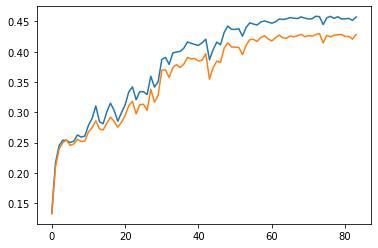

In [295]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# Predictions

In [332]:
X_valid = X_test
y_valid = y_test
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
preds = clf.predict_proba(X_valid)
y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
valid_acc = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL VALID SCORE FOR : {valid_acc}")

BEST VALID SCORE FOR : 0.43014301430143015
FINAL VALID SCORE FOR : 0.43014301430143015


In [338]:
def add_topk(df,col):
        var = np.argsort(np.array(df[col].values.tolist()))
        df[f'top{1}'] = var[:,-1]
        df[f'top{2}'] = var[:,-2]
        df[f'top{3}'] = var[:,-3]
        return df
c = []
for i in x_col:
    if 'shop' in i:
        c.append(int(i.split('_')[-1]))
preds = pd.DataFrame(preds,columns = c)
add_topk(preds,col =c)
官方指認欄位 = [2,6,10,12,13,15,18,19,21,22,25,26,36,37,39,48]
mapping = dict(zip([*range(len(官方指認欄位))],官方指認欄位))
for col in ['top1','top2','top3']:
    preds[col] = preds[col].apply(lambda x:mapping[x]) # 轉換
preds[['top1','top2','top3']]

,top1,top2,top3
0,48,2,15
1,10,19,37
2,10,2,15
3,48,37,2
4,37,15,36
...,...,...,...
9994,10,48,15
9995,10,48,19
9996,22,48,2
9997,37,48,15


In [340]:
a = preds[['top1']]
b = pd.DataFrame(y_valid,columns=['top1'])
b

,top1
0,48
1,15
2,19
3,15
4,19
...,...
9994,10
9995,10
9996,37
9997,37


In [348]:
a.values.reshape(-1)
b.values.reshape(-1)

array([48, 15, 19, ..., 37, 37, 48], dtype=int64)

In [350]:
from sklearn.metrics import accuracy_score
accuracy_score(a,b)

0.43014301430143015